# Reinforcement Learning based Trading Strategy

In this case study, we will create an end-to-end trading strategy based on Reinforcement Learning. 


This model is based on Tatsat's model in Machine Learning and Data Science Blueprints for Finance at: <br> https://github.com/tatsath/fin-ml <br>
However, the original code was not running so this version has:<br>
1. a new act() function that forbids naked shorting <br>
2. the use of leaky relu activations instead of relu <br>
3. a new leaky sigmoid function <br>
4. the use of random sampling in expReplay <br>
5. various new plotting functions <br>
6. many new commentsa and corrections to the original comments <br>
The new act() function was written by Yunkun Yang, the ANN was also modified by him.<br>

In [1]:
#Characteristics of this model:
#model less,
#temporal differences (TD) algorithm,
#off-policy algorithm,
#Q-learning (an adaptation of TD),
#Deep Q learning (=Q-learning+ANN).

#There is no Q_table: the Q_table is replaced by a ANN

#The ANN:
#The ANN takes as input the current state (the logistic squashed price difference) and 
#tries to predict the Q-values of the 3 actions (hold, buy & sell). 

#Lookahead:
#A regular ANN predicts a static target.
#Here the target of the ANN is not static:
#At each step, the ANN target is updated by using the Bellman eq. that 
#includes a prediction of the ANN (w/input=next_state)
#After this, the ANN gets fitted on this updated target (w/input=current state)


#           if not done:
#                #set_trace()
#                #max of the array of the predicted. 
#                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])   #BELLMAN EQUATION  
                
            # Q-value of the state currently from the array    
#            target_f = self.model.predict(state)
#            # Update the output Q array for the given action in the array     
#            target_f[0][action] = target
#            #train and fit the model where state is X and target_f is Y, where the target is updated. 
#            self.model.fit(state, target_f, epochs=1, verbose=0) #FITTING OF ANN ON UPDATED target

#The loss function that the ANN is minimizing is the mean of the sum of the squared residuals (Y - Y_hat):
#residual = the discrepancy between the updated target Q-values and the predicted Q-values
#residual = [reward + self.gamma * np.amax(self.model.predict(next_state)[0])]-[self.model.predict(state)]
#Note that both terms in the residual are actually estimated by the ANN, so we have Y_hat_next - Y_hat_current

#The ANN residual has 2 sources of error:
#the estimation error (e.g. initialization error).This exists in both Y_hats and tends to cancel out.
#the error associated with EPSILON randomness.

#Overfitting by the agent in this setup is "memorization" by the ANN 
#of the EPSILON randomness which helps the agent explore the environment
#EPSILON is reset at the begining of each episode
#EPSILON decays exponentially with the number of steps in the episode.

#Increasing the episode_count beyond a certain point 
#may lead to a degradation in the agent's performance on the test set. 
#If the agent is given too many episodes to train on the same data, 
#it may start to memorize the specific patterns and sequences of the training set, which 
#could lead to poor generalization to new, unseen data.

#In reinforcement learning checkpoints of type Keras ModelCheckpoint based on history
#history = self.model.fit(state, target_f, validation_split=0.20, epochs=1, verbose=0)  
#are NOT used to prevent overfitting, since X and Y are single samples 
#You have to keep track of the history of training and validation loss with your own programming

#Measures to prevent overfitting
#See the section: PREVENTING OVERFITTING WITHOUT A TEST SET
#In this program the validation set is called test set.
#You can use the profits of the training sest to select the best saved model.
#And then you can validate the best saved model using the validation set. 
#Other helpful plots are:
#The plot entitled "MSE_median of ANN" that measures the ANN MSE during training.
#The plot entitled "Equity Curve" that illustrates the volatility of the profits and losses of the validation set.

#The line: pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv") 
#is used to help the programmer identify overfitting by the agent.
#This line converts the agent's memory into a DataFrame and saves it as a CSV file, 
#allowing you to analyze and inspect the agent's experiences and performance during each episode of training. 
#The resulting CSV file will have columns representing 
#the state, action, reward, next_state, and done values for each experience in the agent's memory.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1) 
* [5.Evaluate Algorithms and Models](#5) 
    * [5.1. Train Test Split](#5.1)
    * [5.2. Implementation steps and modules](#5.2)
    * [5.3. Agent Script](#5.3)
    * [5.4. Helper Function](#5.4)
    * [5.5. Training Set](#5.5)       

* [6.Test Set](#6)           

<a id='0'></a>
# 1. Problem Definition

In this Reinforcement Learning framework for trading strategy, the algorithm takes an action (buy, sell or hold) depending upon the current state of the stock price. The algorithm is trained using Deep Q-Learning framework, to help us predict
the best action, based on the current stock prices. 

The key components of the RL based framework are :
* Agent: Trading agent.
* Action: Buy, sell or hold.
* Reward function: Realized profit and loss (PnL) is used as the reward function
for this case study. The reward depends upon the action:
    * Sell: Realized profit and loss (sell price - bought price)
    * Buy: No reward
    * Hold: No Reward 

* State: Differences of past stock prices for a given time window is used as the state.

The data used for this case study will be the standard and poor's 500. The link to the data is : https://ca.finance.yahoo.com/quote/%255EGSPC/history?p=%255EGSPC).

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from collections import namedtuple, deque

Using TensorFlow backend.
C:\Users\User\anaconda3\envs\tatsat\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\anaconda3\envs\tatsat\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\anaconda3\envs\tatsat\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\anaconda3\envs\tatsat\lib\site-pa

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('data/SP500Smoothed.csv',index_col=0)

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

In [6]:
# shape
dataset.shape

(2512, 6)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1/8/2010,1132.344019,1139.507983,1129.541992,1138.663989,1138.663989,4223070000
1/11/2010,1138.223999,1142.681982,1134.633984,1141.461987,1141.461987,4275946000
1/12/2010,1140.454004,1144.117993,1135.055982,1141.401977,1141.401977,4720974000
1/13/2010,1140.774024,1145.960010,1134.902002,1143.109985,1143.109985,4560514000
1/14/2010,1142.656031,1147.550024,1137.398023,1144.463989,1144.463989,4289418000


The data has total 2515 rows and six columns which contain the open, high, low,
close and adjusted close price along with the total volume. The adjusted close is the
closing price adjusted for the split and dividends. For the purpose of this case study,
we will be focusing on the closing price.

In [8]:
# describe data
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2512.000,2512.000,2512.000,2512.000,2512.000,2.512e+03
mean,1961.803,1971.002,1951.850,1962.258,1962.258,3.716e+09
std,587.755,588.964,586.330,587.630,587.630,6.532e+08
min,1031.188,1043.600,1020.412,1029.992,1029.992,1.401e+09
25%,1380.542,1388.536,1372.440,1380.895,1380.895,3.300e+09
50%,1982.246,1992.156,1973.097,1982.626,1982.626,3.648e+09
75%,2435.358,2442.838,2425.325,2434.646,2434.646,3.991e+09
max,3233.204,3237.416,3224.190,3231.076,3231.076,8.075e+09


Let us look at the plot of the stock movement. 

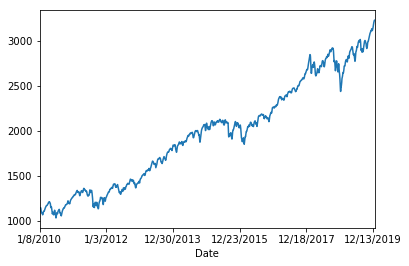

In [9]:
dataset['Close'].plot()

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [10]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In case there are null values fill the missing values with the last value available in the dataset. 

In [11]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1/8/2010,1132.344,1139.508,1129.542,1138.664,1138.664,4223070000
1/11/2010,1138.224,1142.682,1134.634,1141.462,1141.462,4275946000


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='5.1'></a>
## 5.1. Train Test Split

We will use 80% of the dataset for modeling
and use 20% for testing.

In [12]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [13]:
validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

<a id='5.2'></a>
## 5.2. Implementation steps and modules

The algorithm, in simple terms decides whether to buy, sell or hold, when provided
with the current market price. The algorithm is based on “Q-learning based”
approach and used Deep-Q-Network (DQN) to come up with a policy. As discussed
before, the name “Q-learning” comes from the Q(s, a) function, that based on the
state s and provided action a returns the expected reward.


In order to implement this DQN algorithm several functions and modules are implemented that interact with each other during the model training. A summary of the
modules and functions is described below.

1. **Agent Class**: The agent is defined as “Agent” class, that holds the variables and
member functions that perform the Q-Learning that we discussed before. An
object of the “Agent” class is created using the training phase and is used for
training the model.
2. **Helper functions**: In this module, we create additional functions that are helpful
for training. There are two helper functions that we have are as follows.
3. **Training module**: In this step, we perform the training of the data using the vari‐
ables and the functions agent and helper methods. This will provide us with one
of three actions (i.e. buy, sell or hold) based on the states of the stock prices at the
end of the day. During training, the prescribed action for each day is predicted,
the rewards are computed and the deep-learning based Q-learning model
weights are updated iteratively over a number of episodes. Additionally, the profit
and loss of each action is summed up to see whether an overall profit has occur‐
red. The aim is to maximize the total profit.
We provide a deep dive into the interaction between different modules and functions
in the “Training the model” section below.
Let us look at the each of the modules in detail

<a id='5.3'></a>
## 5.3. Agent script

The definition of the Agent script is the key step, as it consists of the In this section, we will train an agent that will perform reinforcement learning based on the Q-Learning. We will perform the following steps to achieve this:

* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
    * Constructor: The constructor inititalises all the parameters.
    * Model : This function has a deep learning model to map the state to action.
    * Act function :Returns an action, given a state, using the  output of the model function. The number of actions are defined as 3: hold, buy, sell
    * expReplay : After each act, randomly sample a mini-batch of experiences from memory. Using each experience in the mini-batch, fit the network with the objective of minimizing the difference between the updated target action Q-value and the predicted action Q-value. Because expReplay is ordered after the act function is called, the entire first episode plot shows the result of trading with no fitting. Note that the shuffling occurs at the level of experiences, no shuffling occurs within the window of the state.

Experience replay increases the size of the samples, reduces the autocorrelation of samples that are collected during online learning, and limits the feedback that can lead to local minima or divergence.

In [14]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name="", target_model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size + 2# normalized previous days, 
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory_long = deque(maxlen=1000)
        self.inventory_short = deque(maxlen=1000)
        self.model_name = model_name
        self.target_model_name = target_model_name
        self.is_eval = is_eval

        self.gamma = 0.95 # 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9
        
        #self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model()
        self.target_model = load_model(target_model_name) if is_eval else self._build_target_model()
        self.update_target_model()
    
    #build target_model
    def _build_target_model(self):
        model = Sequential()
        model.add(Dense(units=32, input_dim=self.state_size))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(units=32))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(units=8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.01))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())


    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=32, input_dim=self.state_size)) #original 64; original relu
        model.add(LeakyReLU(alpha=0.2))
        #Hidden Layers
        #model.add(Dense(units=32)) #or comment out; original relu
        #model.add(LeakyReLU(alpha=0.2)) #or comment out; original relu
        model.add(Dense(units=8))
        model.add(LeakyReLU(alpha=0.2))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.01)) #original .001 
        return model
    
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.
 
    def act(self, state): 
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if (not self.is_eval and (random.random() <= self.epsilon)):
            return random.randrange(self.action_size) 
        options = self.model.predict(state)
        action = np.argmax(options[0])
        return action  

    def expReplay(self, batch_size):
        res = deque(maxlen=1000)
        mini_batch = []
        l = len(self.memory)
        
        #for i in range(l - batch_size + 1, l):
            #mini_batch.append(self.memory[i])
        mini_batch = random.sample(self.memory, batch_size)            
        
        exp = 0
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            #update the Q array based on Q array equation
            #set_trace()
            if not done:
                #set_trace()
                #amax = max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
                
            # Q-value of the state currently from the array    
            target_f = self.model.predict(state)
            res.append(target - target_f[0][action])
            # Update the output Q array for the given action in the array     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)
            update_frequency = 2
            if exp % update_frequency == 0:
                self.update_target_model()
            exp += 1
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return np.mean(np.square(res)) #return the mse of the residuals

<a id='5.4'></a>
## 5.4. Helper Functions

In this script, we will create functions that will be helpful for training. We create the following functions:

1) formatPrice:format the price to two decimal places, to reduce the ambiguity of the data:

2) getStockData: Return a vector of stock data from the CSV file. Convert the closing stock prices from the data to vectors, and return a vector of all stock prices.

3) getState: Define a function to generate states from the input vector. Create the time series by generating the states from the vectors created in the previous step. The function for this takes three parameters: the data; a time, t (the day that you want to predict); and a window (how many days to go back in time). The rate of change between these vectors will then be measured and based on the sigmoid function.

In [15]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    #instead of 1 / (1 + math.exp(-x))
    return leaky_sigmoid(x)

#In leaky_sigmoid, the parameter alpha controls the slope of the linear part. 
#A value of alpha between 0 and 1 determines the extent of linearity and 
#the degree of squashing. A smaller alpha value provides a more linear region.

def leaky_sigmoid(x, alpha=0.2):
    return (2 / (1 + np.exp(-alpha*x))) - 1

# returns an an n-day state representation ending at time t

def getState(data, t, n): 
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    pos = [0]
    neg =  [0]
    for i in range(n - 1):
        res.append(sigmoid(block[n-1] - block[i]))
        if (block[i + 1] - block[i]>0):
            pos.append(block[i + 1] - block[i])
        else:
            neg.append(block[i + 1] - block[i])
    #res.append(sigmoid(len(agent.inventory_short)))
    #res.append(sigmoid(len(agent.inventory_long)))
    res.append(sigmoid(np.mean(pos)))
    res.append(sigmoid(np.mean(neg)))
    return np.array([res])


# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

<a id='5.5'></a>
## 5.5. Training the data

We will proceed to train the data, based on our agent and helper methods. This will provide us with one of three actions, based on the states of the stock prices at the end of the day. These states can be to buy, sell, or hold. During training, the prescribed action for each day is predicted, and the price (profit, loss, or unchanged) of the action is calculated. The cumulative sum will be calculated at the end of the training period, and we will see whether there has been a profit or a loss. The aim is to maximize the total profit.

Steps: 
* Define the number of market days to consider as the window size and define the batch size with which the neural network will be trained.
* Instantiate the stock agent with the window size and batch size.
* Read the training data from the CSV file, using the helper function.
* The episode count is defined. The agent will look at the data for so many numbers of times. An episode represents a complete pass over the data.
* We can start to iterate through the episodes.
* Each episode has to be started with a state based on the data and window size. The inventory of stocks is initialized before going through the data.
* **Start to iterate over every day of the stock data. The action Q_value is predicted by the ANN**. 
* Next, every day of trading is iterated, and the agent can act upon the data. Every day, the agent decides an action. Based on the action, the stock is held, sold, or bought.
* If the action is 1, then agent buys the stock. 
* If the action is 2, the agent sells the stocks and removes it from the inventory. Based on the sale, the profit (or loss) is calculated.

* If the action is 0, then there is no trade. The state can be called holding during that period.
* The details of the state, next state, action etc is saved in the memory of the agent object, which is used further by the exeReply function.         


**MAIN PROGRAM: Q-LEARNING ALGORITHM**

Instructions for updating:
Colocations handled automatically by placer.
Running episode 0/20
Instructions for updating:
Use tf.cast instead.
--------------------------------
Total Profit: -$1251.05
--------------------------------


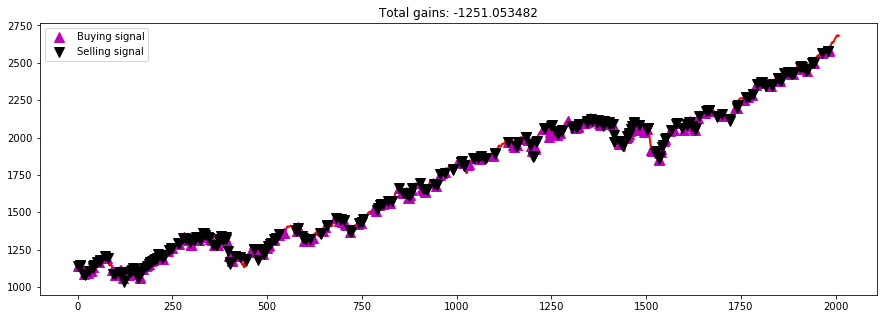

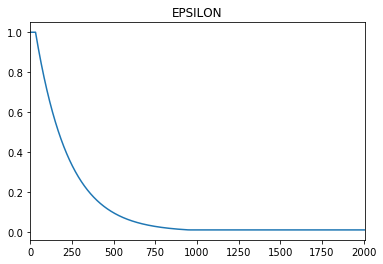

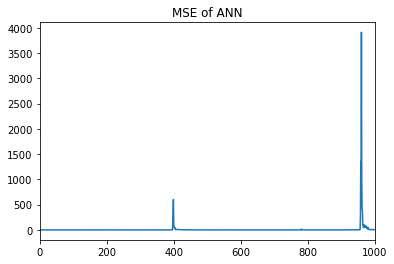

Running episode 1/20
--------------------------------
Total Profit: -$1788.99
--------------------------------


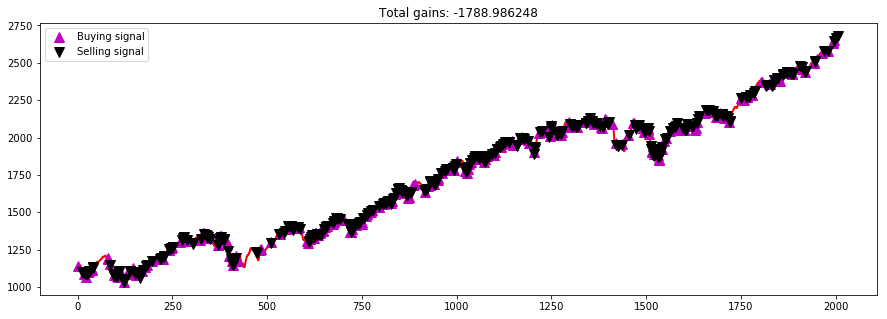

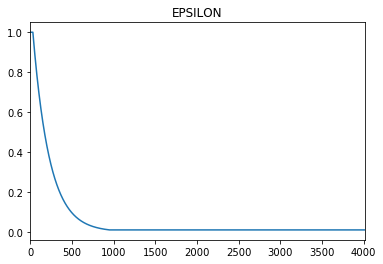

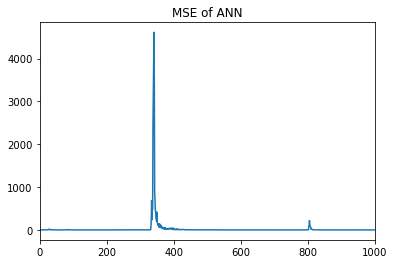

Running episode 2/20
--------------------------------
Total Profit: -$1523.18
--------------------------------


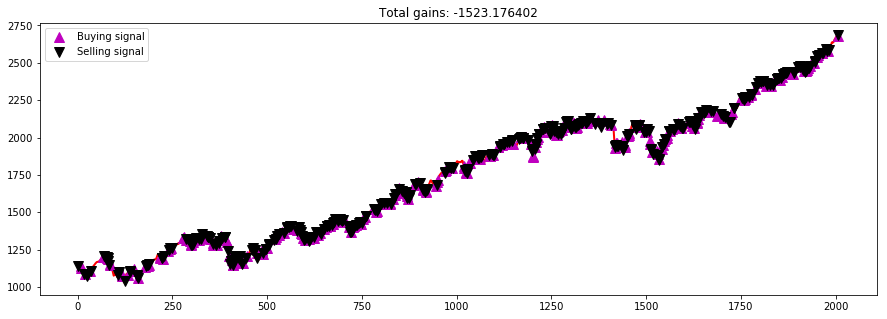

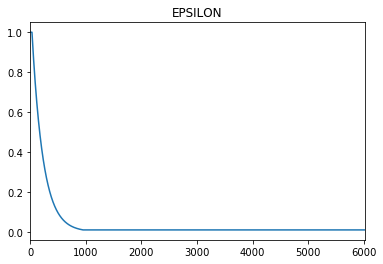

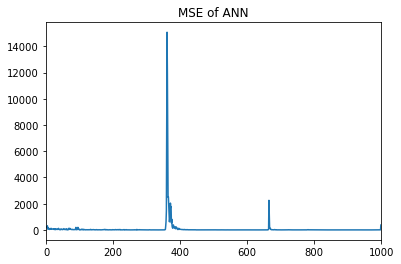

Running episode 3/20
--------------------------------
Total Profit: -$1714.81
--------------------------------


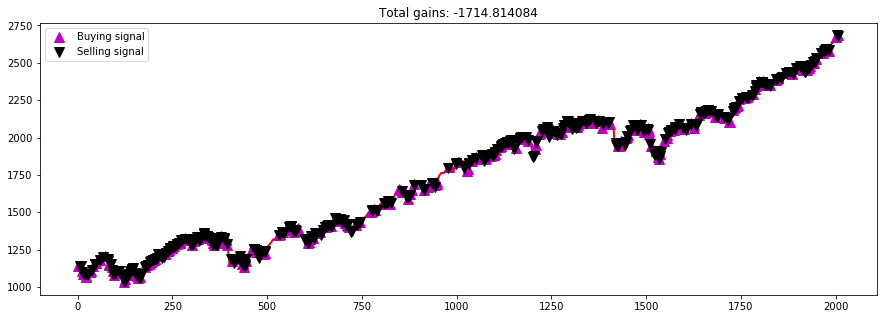

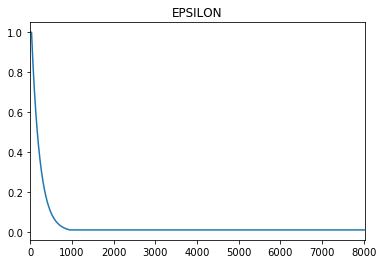

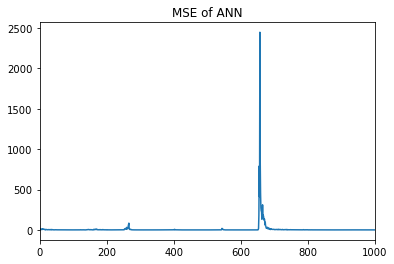

Running episode 4/20
--------------------------------
Total Profit: -$994.17
--------------------------------


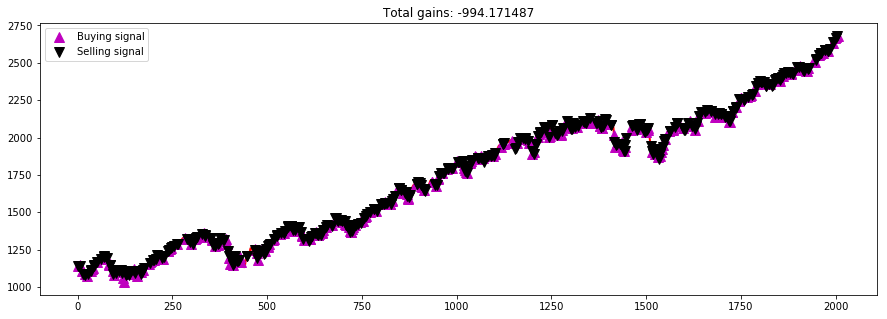

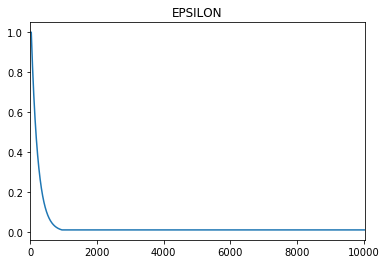

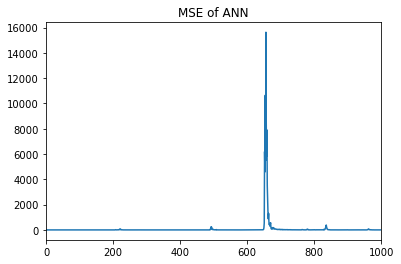

Running episode 5/20
--------------------------------
Total Profit: -$1710.91
--------------------------------


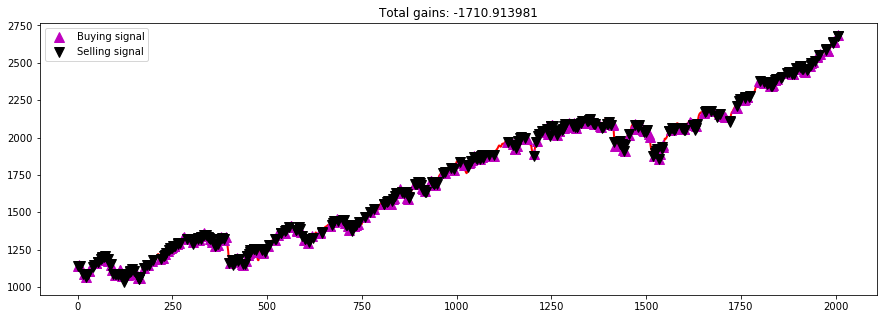

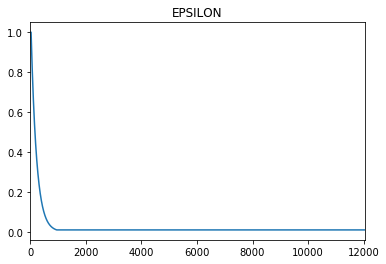

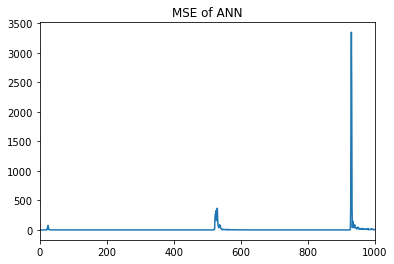

Running episode 6/20
--------------------------------
Total Profit: -$1754.48
--------------------------------


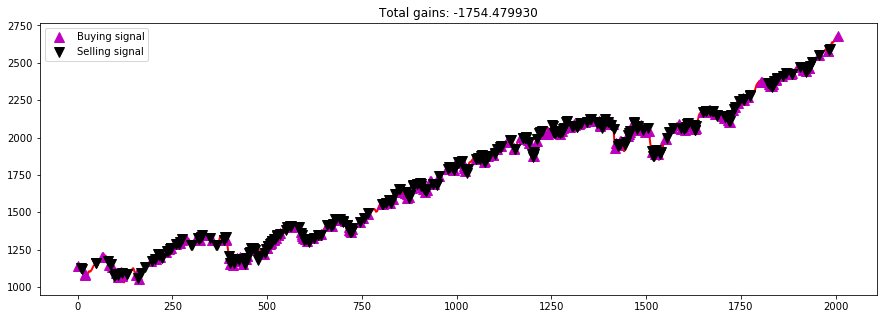

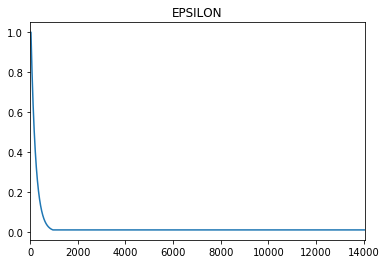

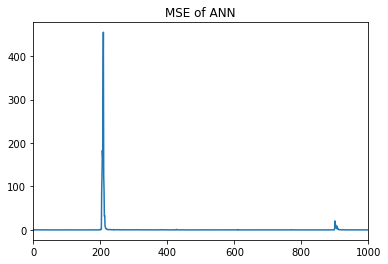

Running episode 7/20
--------------------------------
Total Profit: -$1912.08
--------------------------------


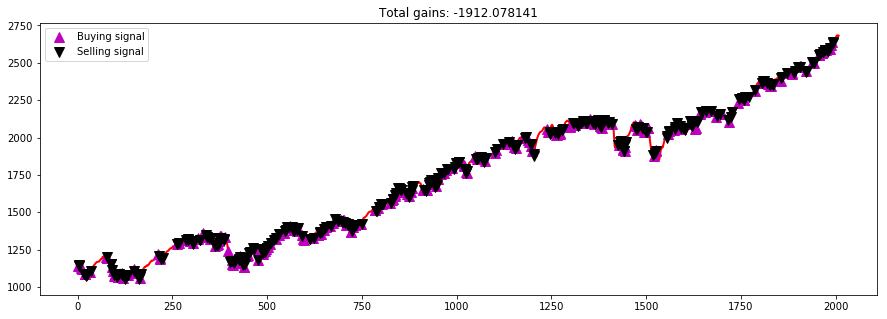

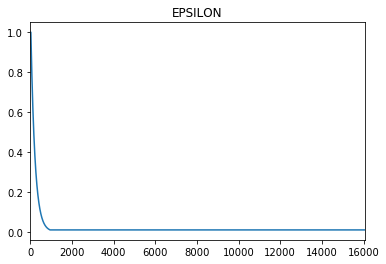

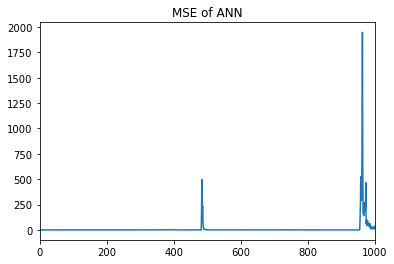

Running episode 8/20
--------------------------------
Total Profit: -$924.77
--------------------------------


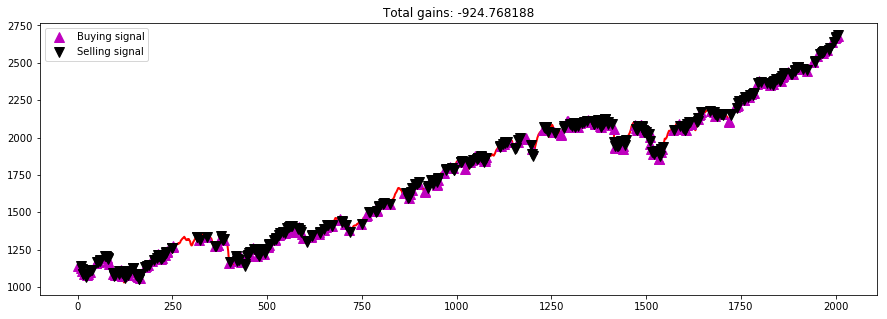

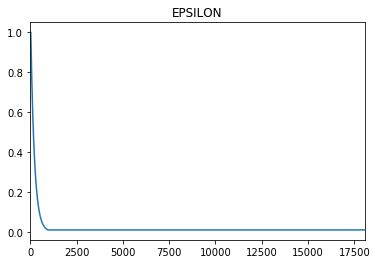

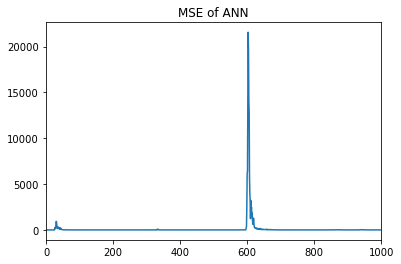

Running episode 9/20
--------------------------------
Total Profit: -$1626.20
--------------------------------


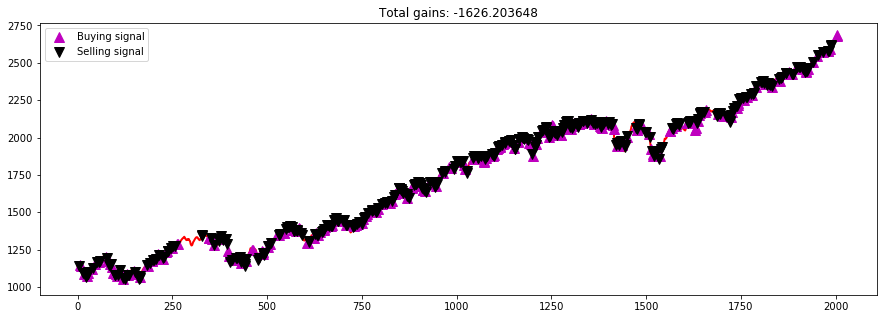

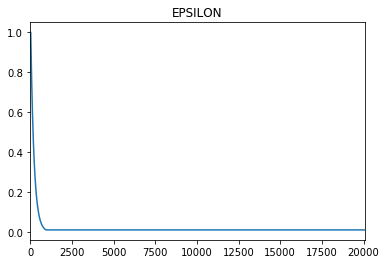

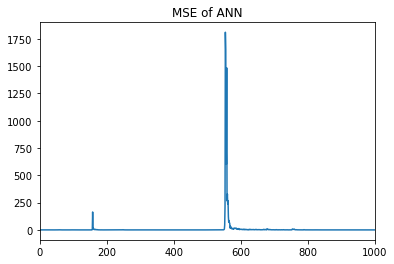

Running episode 10/20
--------------------------------
Total Profit: -$781.79
--------------------------------


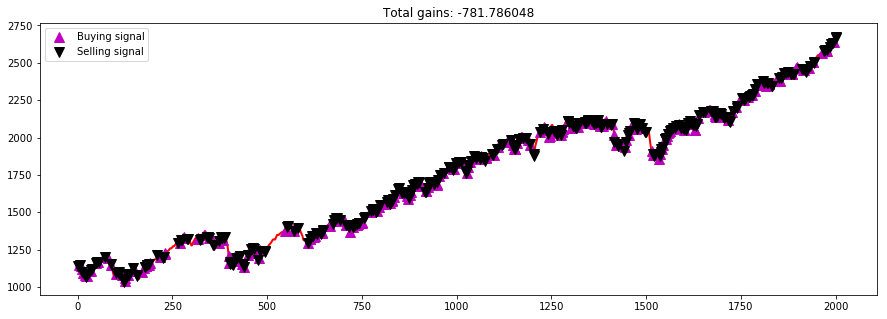

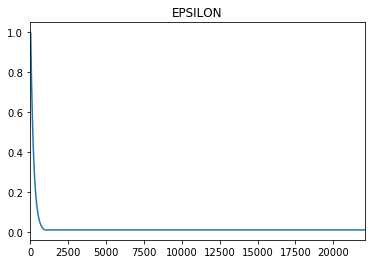

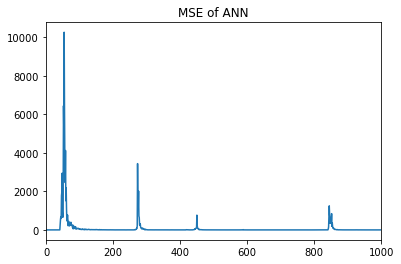

Running episode 11/20
--------------------------------
Total Profit: -$2054.37
--------------------------------


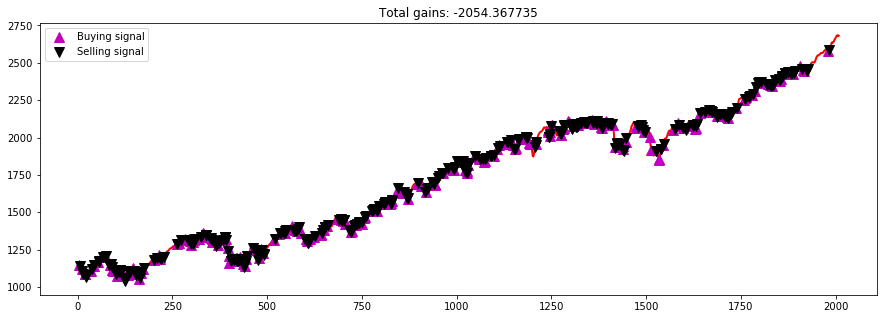

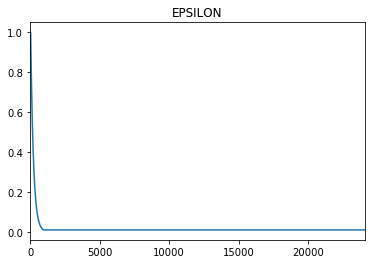

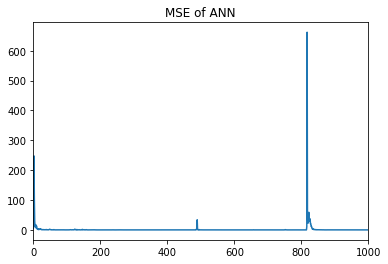

Running episode 12/20
--------------------------------
Total Profit: -$1184.33
--------------------------------


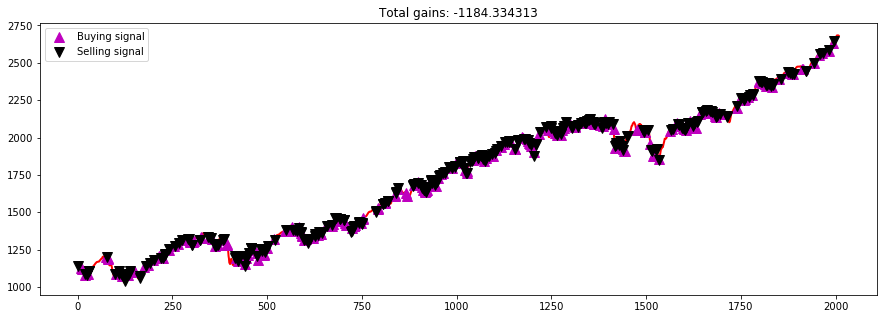

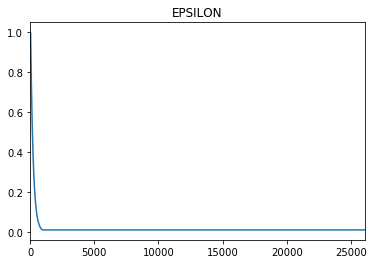

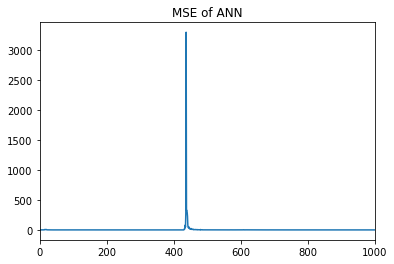

Running episode 13/20
--------------------------------
Total Profit: -$1420.03
--------------------------------


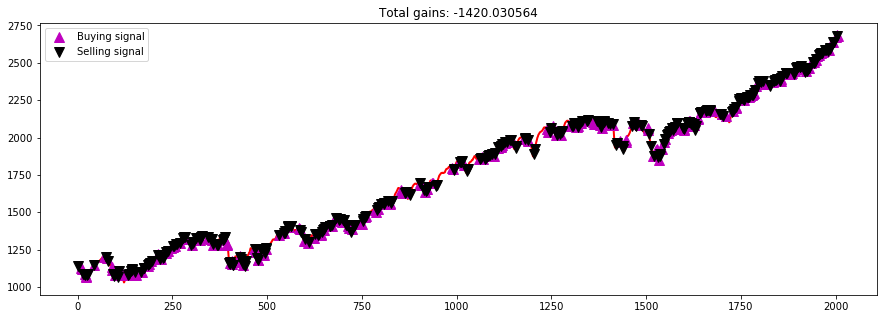

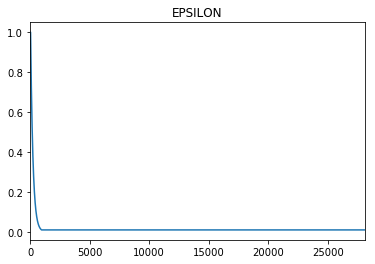

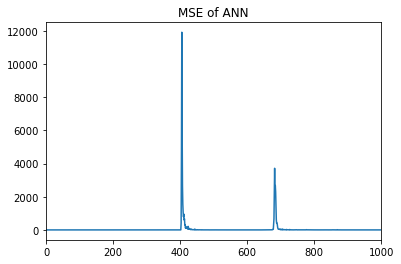

Running episode 14/20
--------------------------------
Total Profit: -$2140.76
--------------------------------


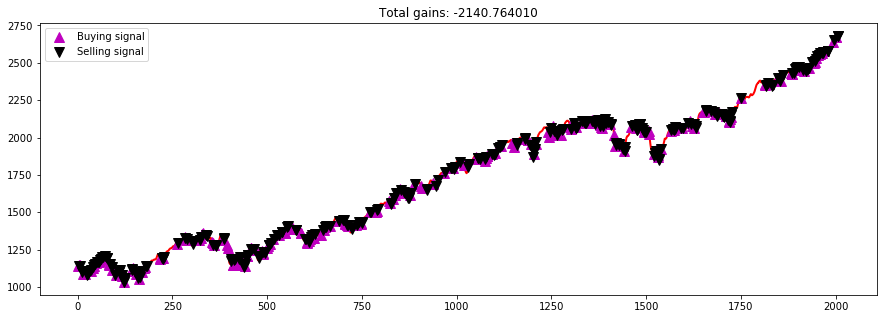

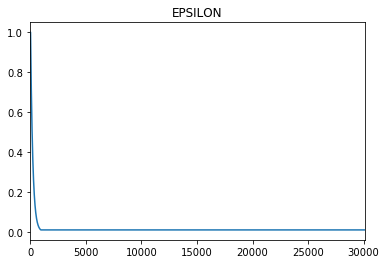

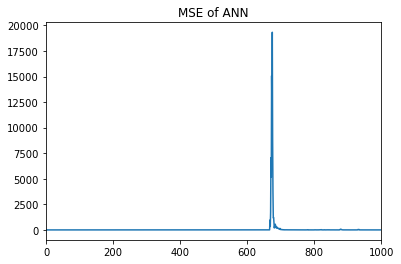

Running episode 15/20
--------------------------------
Total Profit: -$1042.36
--------------------------------


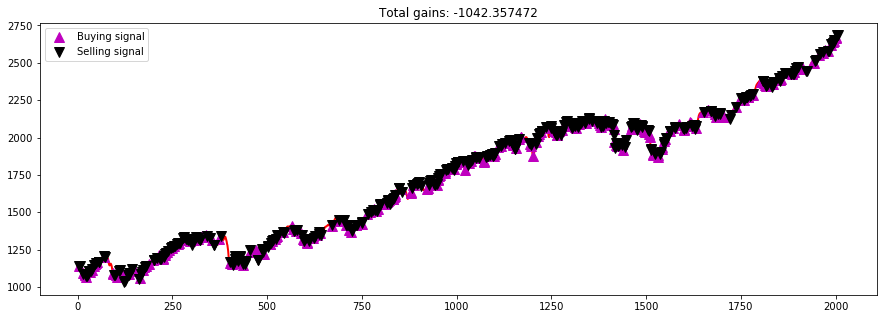

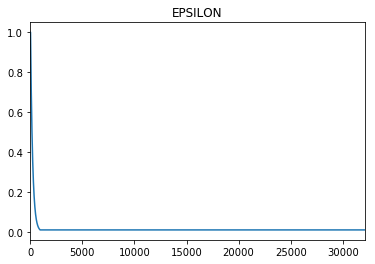

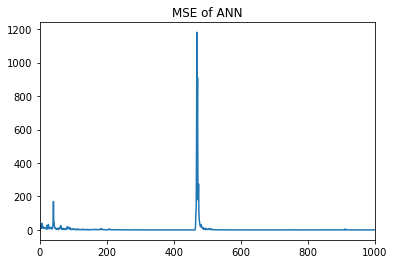

Running episode 16/20
--------------------------------
Total Profit: -$1846.62
--------------------------------


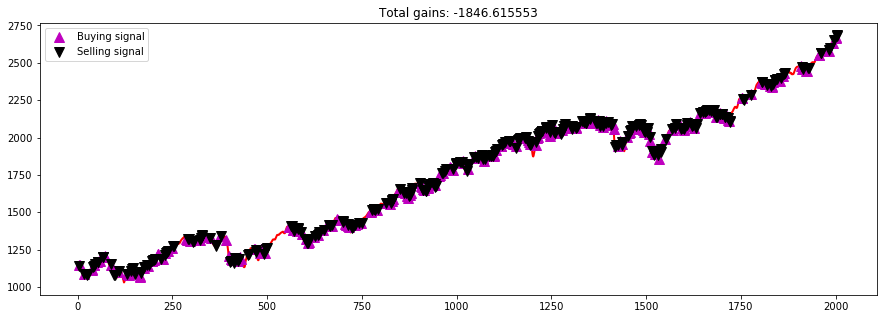

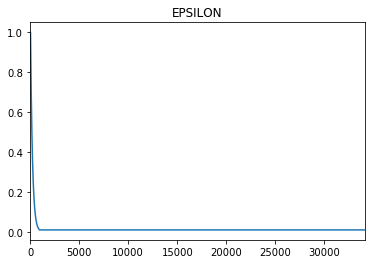

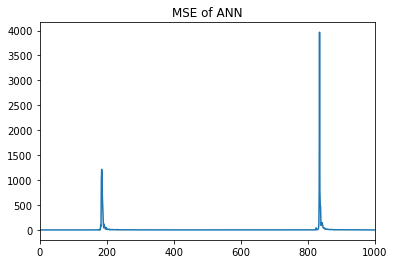

Running episode 17/20
--------------------------------
Total Profit: -$1058.13
--------------------------------


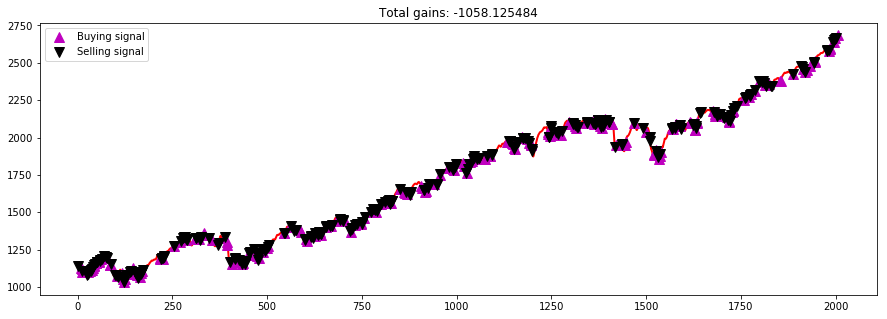

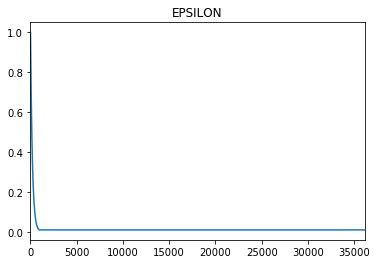

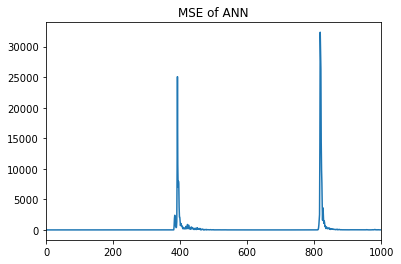

Running episode 18/20
--------------------------------
Total Profit: -$1716.08
--------------------------------


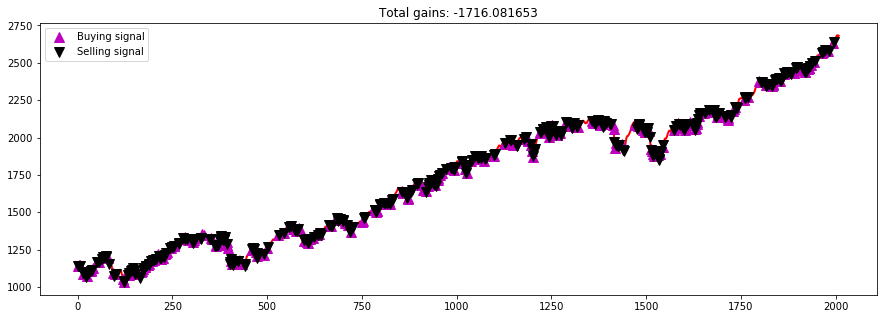

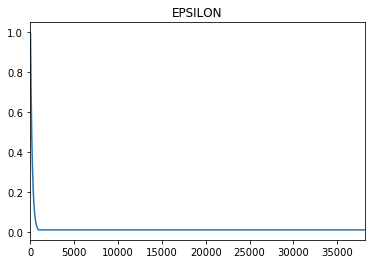

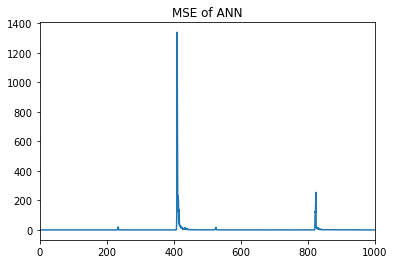

Running episode 19/20
--------------------------------
Total Profit: -$1738.76
--------------------------------


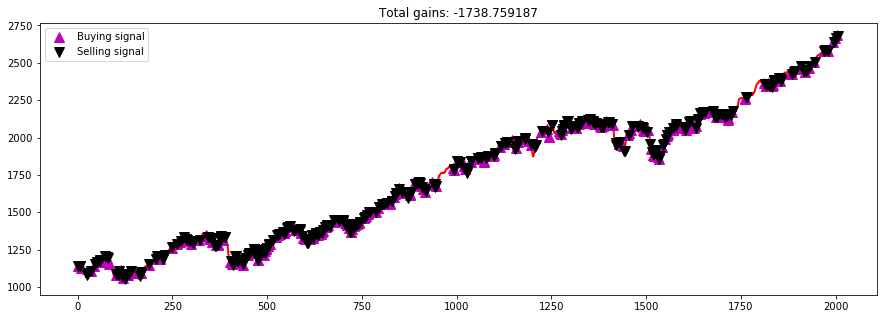

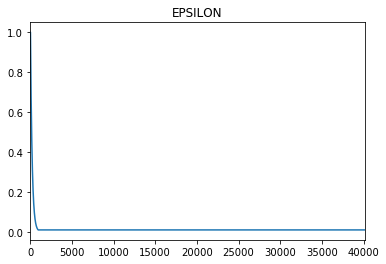

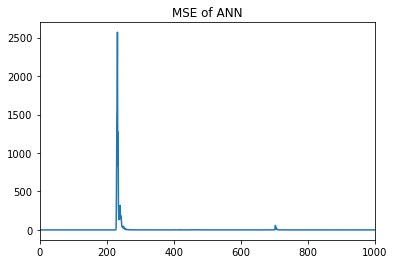

Running episode 20/20
--------------------------------
Total Profit: -$1655.62
--------------------------------


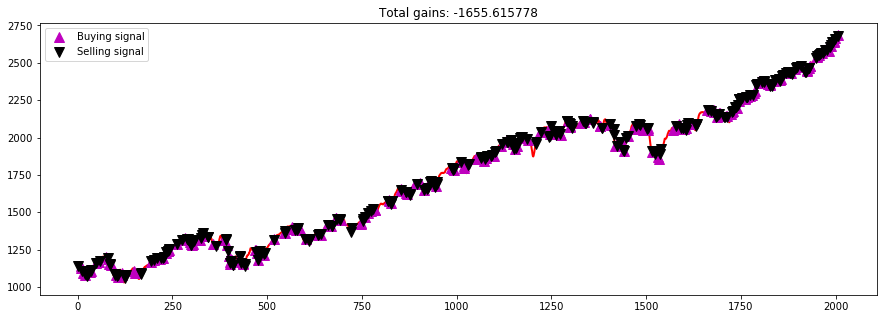

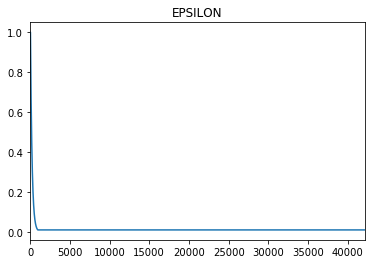

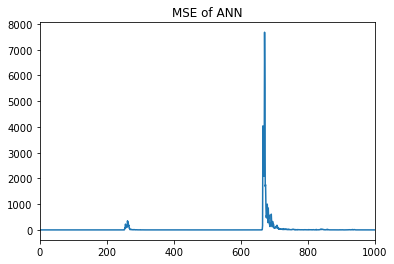

In [16]:
from IPython.core.debugger import set_trace
window_size = 15
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 20 ##########################################################################################################

msqe = deque(maxlen=1000)
msqe_median = []

mye = []
mye.append(agent.epsilon)
for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory_short = deque(maxlen=1000)
    agent.inventory_long = deque(maxlen=1000)
    agent.inventory_short_t = deque(maxlen=1000)
    agent.inventory_long_t = deque(maxlen=1000)
    
    states_sell = []
    states_buy = []
    
    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

#NOTE: this setup allows the agent to accumulate at most one contract.
#To accumulate more than one contract:
#distinguish 5 actions: buy_reverse, buy_accumulate, sell_reverse, sell_accumulate, hold

        if action == 1: #buy
            if len(agent.inventory_short)>0:
                short_price = agent.inventory_short.popleft() #FIFO
                short_price_t = agent.inventory_short_t.popleft() #FIFO
                reward = -(data[t] - short_price)/(np.abs(t-short_price_t)) #reverse a previous short
                if reward < 0:
                    reward = 2*reward
                total_profit += -(data[t] - short_price) #reverse a previous short
                 #print("Buy: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - short_price))
                states_buy.append(t)
            elif len(agent.inventory_long)==0:
                agent.inventory_long.append(data[t]) #save the long_price on top of stack
                agent.inventory_long_t.append(t)
                states_buy.append(t)
            
        if action == 2: #sell
            if len(agent.inventory_long)>0:
                long_price = agent.inventory_long.popleft() #FIFO
                long_price_t = agent.inventory_long_t.popleft() #FIFO
                reward = (data[t] - long_price)/(np.abs(t-long_price_t))#reverse a previous long
                total_profit += (data[t] - long_price) #reverse a previous long
                #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - long_price))
                states_sell.append(t)
            elif len(agent.inventory_short)==0:
                agent.inventory_short.append(data[t]) #save the short_price on top of stack
                agent.inventory_short_t.append(t)
                states_sell.append(t)
              

        reward = sigmoid(reward)    #this will enhance ANN convergence
        
        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
             msqe.append(agent.expReplay(batch_size))
                
        mye.append(agent.epsilon) 
            
    pd.Series(mye).plot(title="EPSILON") 
    plt.show()
    pd.Series(msqe).plot(title="MSE of ANN")
    plt.show()
    msqe_median.append(pd.Series(msqe).median())
    #print("median MSE of ANN", pd.Series(msqe).median())
    #if e % 2 == 0:
    agent.model.save("model_ep" + str(e))
    agent.target_model.save("target_model_ep" + str(e))

In [17]:
#Deep Q-Learning Model
print(agent.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                576       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 867
Trainable params: 867
Non-trainable params: 0
_________________________________________________________________
None


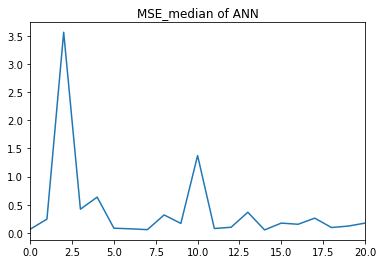

In [18]:
pd.Series(msqe_median).plot(title="MSE_median of ANN")

**LOOP THROUGH ALL SAVED MODELS**

In [19]:
#Above you saw the trading history plot of each episode, 
#but during each eposode the agent retrains at each step, and then
#each model is saved at the end of the episode, 
#so the trading history plots do NOT reflect the trading performance of the saved models. 
#This is why we will now loop through all the saved models and
#look at the profits of their actual trading performance.

In [20]:
from IPython.core.debugger import set_trace
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
is_eval = True

#
for e in range(episode_count + 1):
    #Get the trained model
    model_name = "model_ep"+str(e)
    target_model_name = "target_model_ep"+str(episode_count)
    agent = Agent(window_size, is_eval, model_name, target_model_name)
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory_short = deque(maxlen=1000)
    agent.inventory_long = deque(maxlen=1000)
    states_sell = []
    states_buy = []

    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: #buy
            if len(agent.inventory_short)>0:
                short_price = agent.inventory_short.popleft() #FIFO
                total_profit += -(data[t] - short_price) #reverse a previous short
                 #print("Buy: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - short_price))
                states_buy.append(t)
            elif len(agent.inventory_long)==0:
                agent.inventory_long.append(data[t]) #save the long_price on top of stack
                states_buy.append(t)
            
        if action == 2: #sell
            if len(agent.inventory_long)>0:
                long_price = agent.inventory_long.popleft() #FIFO
                total_profit += data[t] - long_price #reverse a previous long
                #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - long_price))
                states_sell.append(t)  
            elif len(agent.inventory_short)==0:
                agent.inventory_short.append(data[t]) #save the short_price on top of stack
                states_sell.append(t)           
            
        done = True if t == l - 1 else False
        state = next_state

        if done:
            extra_profit = 0
            for s in list(range(0,len(agent.inventory_long))): #reverse all long positions
                long_price = agent.inventory_long.popleft()
                extra_profit += data[t] - long_price
            for s in list(range(0,len(agent.inventory_short))):#reverse all short position
                short_price = agent.inventory_short.popleft()
                extra_profit += -(data[t] - short_price)
            print("--------------------------------")
            print("Total Profit of Model " + str(e) + ": " + formatPrice(total_profit) + " + " + formatPrice(extra_profit))
            print("--------------------------------")

train_profit = total_profit #for the last model

--------------------------------
Total Profit of Model 0: $109.77 + $101.66
--------------------------------
--------------------------------
Total Profit of Model 1: -$3135.86 + -$224.45
--------------------------------
--------------------------------
Total Profit of Model 2: -$2748.53 + -$91.81
--------------------------------
--------------------------------
Total Profit of Model 3: $0.00 + $1545.05
--------------------------------
--------------------------------
Total Profit of Model 4: $0.00 + $1545.05
--------------------------------
--------------------------------
Total Profit of Model 5: $2616.54 + -$1.66
--------------------------------
--------------------------------
Total Profit of Model 6: -$1061.79 + -$605.14
--------------------------------
--------------------------------
Total Profit of Model 7: $1558.95 + $91.81
--------------------------------
--------------------------------
Total Profit of Model 8: -$1575.88 + -$104.46
--------------------------------
----------

<a id='6'></a>
# 6. Testing the Data 

After training the data, it is tested it against the test dataset. Our model resulted in a overall profit. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.

In [31]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
pnl = np.zeros(l_test)
#Get the trained model
episode_count = 5##########################################################################################################
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name, target_model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory_short = deque(maxlen=1000)
agent.inventory_long = deque(maxlen=1000)

Buy acc: $2690.53
Sell: $2845.12 | Profit: $154.60
Sell acc: $2842.38
Buy: $2775.86 | Profit: -$66.52
Buy acc: $2750.40
Sell: $2732.54 | Profit: -$17.86
Sell acc: $2721.33
Buy: $2706.36 | Profit: -$14.96
Buy acc: $2708.96
Sell: $2759.43 | Profit: $50.47
Sell acc: $2745.41
Buy: $2707.50 | Profit: -$37.91
Buy acc: $2674.75
Sell: $2689.72 | Profit: $14.97
Sell acc: $2675.35
Buy: $2656.22 | Profit: -$19.13
Buy acc: $2651.77
Sell: $2722.38 | Profit: $70.61
Sell acc: $2719.43
Buy: $2724.77 | Profit: $5.34
Buy acc: $2726.29
Sell: $2719.34 | Profit: -$6.96
Buy acc: $2713.65
Sell: $2781.33 | Profit: $67.68
Sell acc: $2779.68
Buy: $2761.66 | Profit: -$18.02
Buy acc: $2750.32
Sell: $2805.98 | Profit: $55.66
Sell acc: $2807.69
Buy: $2815.95 | Profit: $8.26
Buy acc: $2822.54
Sell: $2825.07 | Profit: $2.52
Sell acc: $2824.24
Buy: $2819.96 | Profit: -$4.28
Buy acc: $2829.52
Sell: $2850.68 | Profit: $21.16
Sell acc: $2844.99
Buy: $2834.22 | Profit: -$10.77
Buy acc: $2841.24
Sell: $2902.19 | Profit: $6

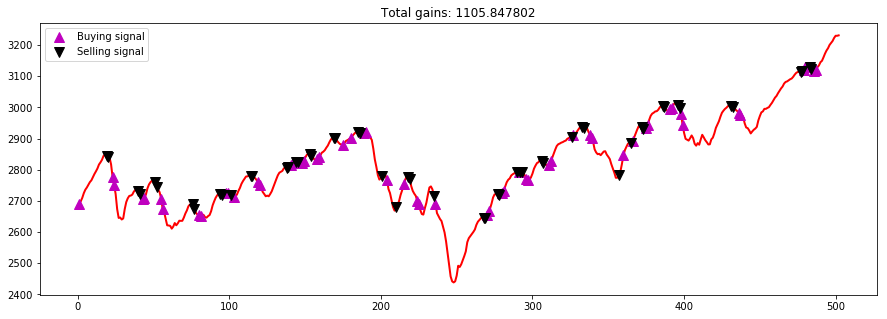

In [32]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0
        
    if action == 1: #buy
        if len(agent.inventory_short)>0:
            short_price = agent.inventory_short.popleft() #FIFO
            total_profit += -(test_data[t] - short_price) #reverse a previous short
            print("Buy: " + formatPrice(test_data[t]) + " | Profit: " + formatPrice(test_data[t] - short_price))
            states_buy_test.append(t)
        elif len(agent.inventory_long)==0:
            agent.inventory_long.append(test_data[t]) #save the long_price on top of stack
            print("Buy acc: " + formatPrice(test_data[t]) )
            states_buy_test.append(t)

    if action == 2: #sell
        if len(agent.inventory_long)>0:
            long_price = agent.inventory_long.popleft() #FIFO
            total_profit += test_data[t] - long_price #reverse a previous long
            print("Sell: " + formatPrice(test_data[t]) + " | Profit: " + formatPrice(test_data[t] - long_price))
            states_sell_test.append(t)     
        elif len(agent.inventory_short)==0:
            agent.inventory_short.append(test_data[t]) #save the short_price on top of stack
            print("Sell acc: " + formatPrice(test_data[t]) )
            states_sell_test.append(t)           
        

    pnl[t] = total_profit    
    if t == l_test - 1:
        done = True
    state = next_state

    if done:
        extra_profit = 0
        for s in list(range(0,len(agent.inventory_long))): #reverse all long positions
            long_price = agent.inventory_long.popleft()
            extra_profit += test_data[t] - long_price
        for s in list(range(0,len(agent.inventory_short))): #reverse all short positions
            short_price = agent.inventory_short.popleft()
            extra_profit += -(test_data[t] - short_price)
        pnl[t] = total_profit + extra_profit
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit) + " + " + formatPrice(extra_profit))
        print("------------------------------------------")
        plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)
        test_profit = total_profit

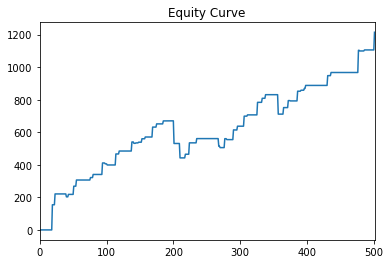

In [33]:
import pandas as pd
pnl = pd.Series(pnl)
pnl.plot(title="Equity Curve")
#This plots the equity curve

Looking at the results above, our model resulted in an overall profit, and we can say that our DQN agent performs quite well on the test set. However, the performance of the model can be further improved by optimizing the hyperparameters as discussed in the model tuning section before. Also, given high complexity and low interpretability of the model, ideally there should be more tests conducted on different time periods before deploying the model for live trading.

**Conclusion**

We observed that we don’t have to decide the strategy or policy
for trading. The algorithm decides the policy by itself, and the overall approach is
much simpler and more principled than the supervised learning-based approach. 

The
policy can be parameterized by a complex model, such as a deep neural network, and
we can learn policies that are more complex and powerful than any rules a human
trader.

We used the testing set to evaluate the model and found an overall profit in the test set.

***MONTE CARLO TEST ON THE TEST DATA SET***

index 0
total_profit 612.6183740779802


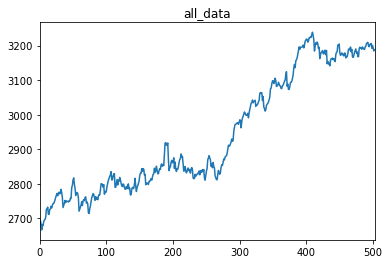

index 1
total_profit 334.1551385918897


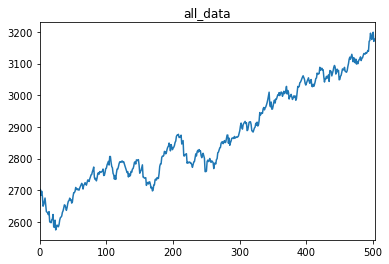

index 2
total_profit 166.23152368566844


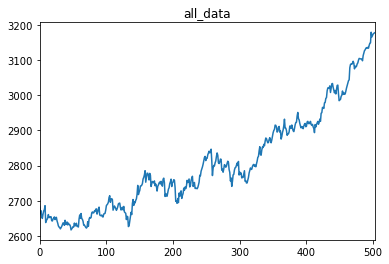

index 3
total_profit 154.74610844811468


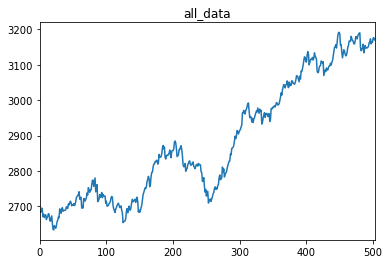

index 4
total_profit 366.9573094235866


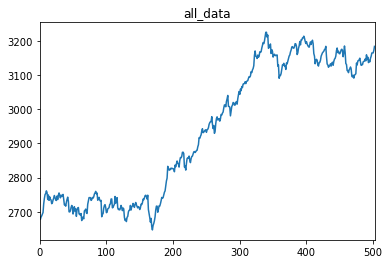

index 5
total_profit 125.46522112103185


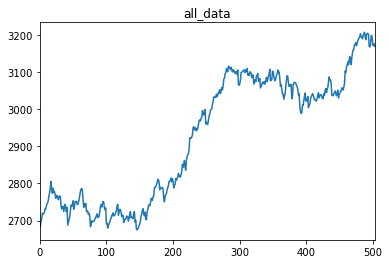

index 6
total_profit 419.88021790858056


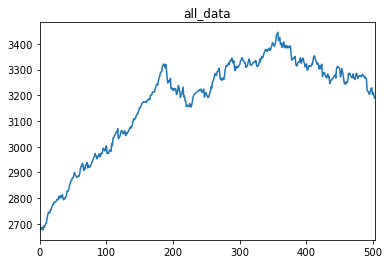

index 7
total_profit 419.24682362167505


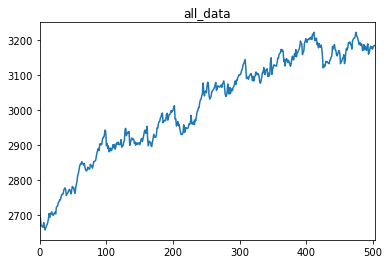

index 8
total_profit -20.661851780958386


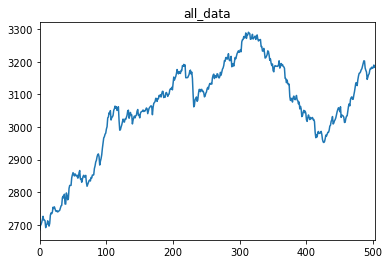

index 9
total_profit 102.7757538290657


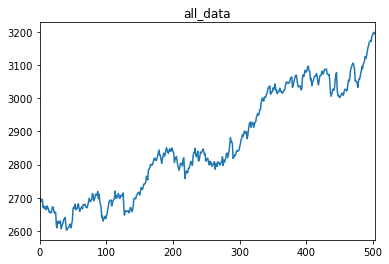

In [34]:
#Below we present a dummy trader
#whose actions reflect the trained model, acting after seeing 
#shuffled squashed price differences (based on shuffled prices) within the ANN's window, 
#whereas by contrast, the prices used to calculate the profits are NOT shuffled.
#So the dummy trader uses the trained model and then trades the true market using shuffled inputs.

#Shuffling:
#We shuffle the prices by shuffling the log returns using Monte Carlo and 
#reconstructing the shuffled prices by 
#multiplying the starting price with the cumulated shuffled log returns.
#This is a better approach than shuffling the prices directly, as 
#it preserves the correct price scale at all times.

#ANN window:
#Note that unlike the shuffling of experiences in expReplay 
#(which shuffles the ANN's windows not their contents)
#the shuffling of prices carried out by Monte Carlo below 
#DOES result in a shuffling of the contents of the ANN's window.

#Trend:
#Since log returns are additive and addition is commutative 
#the overall sum of the log returns is preserved under shuffling
#meaning that the overall price trend is preserved 
#after prices are reconstructed from the shuffled returns

count = 0
N = 10
running_total_profit = 0

for n in range(0, N):
    original_all_data = X_test
    l_all = len(original_all_data) - 1
    XS = pd.Series(X_test)
    returnsXS = np.log(XS) - np.log(XS.shift(1))
    returnsXS = returnsXS.fillna(0)
    returnsXS = returnsXS.to_list()
    shuffledreturnsXS = random.sample(returnsXS, len(returnsXS))
    shuffledreturnsXS[0] = 1
    all_data = np.cumsum(np.array(shuffledreturnsXS)+0)*XS[0] #reconstructed shuffled prices
    all_data = list(all_data) 
    
    state = getState(all_data, 0, window_size + 1)
    total_profit = 0
    is_eval = True
    done = False
    states_sell_all = []
    states_buy_all = []
    pnl = np.zeros(l_all)

    #Get the trained model
    model_name = "model_ep"+str(episode_count)
    target_model_name = "target_model_ep"+str(episode_count)
    agent = Agent(window_size, is_eval, model_name, target_model_name)
    state = getState(all_data, 0, window_size + 1)
    total_profit = 0
    agent.inventory_short = deque(maxlen=1000)
    agent.inventory_long = deque(maxlen=1000)
    
    for t in range(l_all):
        action = agent.act(state)
        #print(action)
        #set_trace()
        next_state = getState(all_data, t + 1, window_size + 1)
        reward = 0
            
        if action == 1: #buy
            if len(agent.inventory_short)>0:
                short_price = agent.inventory_short.popleft() #FIFO
                total_profit += -(all_data[t] - short_price) #reverse a previous short
                 #print("Buy: " + formatPrice(all_data[t]) + " | Profit: " + formatPrice(all_data[t] - short_price))
                states_buy_all.append(t) 
            elif len(agent.inventory_long)==0:
                agent.inventory_long.append(all_data[t]) #save the long_price on top of stack
                states_buy_all.append(t) 
            
        if action == 2: #sell
            if len(agent.inventory_long)>0:
                long_price = agent.inventory_long.popleft() #FIFO
                total_profit += all_data[t] - long_price #reverse a previous long
                #print("Sell: " + formatPrice(all_data[t]) + " | Profit: " + formatPrice(all_data[t] - long_price)) 
                states_sell_all.append(t) 
            elif len(agent.inventory_short)==0:
                agent.inventory_short.append(all_data[t]) #save the short_price on top of stack
                states_sell_all.append(t) 
            
        pnl[t] = total_profit    
        if t == l_all - 1:
            done = True
        state = next_state

        if done:
            #print("------------------------------------------")
            #print("Total Profit: " + formatPrice(total_profit))
            #print("------------------------------------------")
            #plot_behavior(original_all_data,states_buy_all, states_sell_all, total_profit)
            running_total_profit += total_profit
            print ("index", n)
            print ("total_profit", total_profit)
            all_data = pd.Series(all_data)
            all_data.plot(title="all_data")
            plt.show()
            if total_profit > test_profit:
                count += 1

In [35]:
print("The dummy trader's profits > test_profit happen with a probability of: ", (count+1)/(N+1))
#a high probability in this print means is that the profits of the model (test_profit) probably occurred by chance

The dummy trader's profits > test_profit happen with a probability of:  0.09090909090909091


In [36]:
print("running_total_profit/N:", (running_total_profit/N))

running_total_profit/N: 268.1414618926634
